# Part 1: creating the matrix and vector

In this section, I will introduce variables used in creating the matrix and vector. Let $\mathrm{A}$ be an $(N-1)^2$ by $(N-1)^2$ matrix, $\mathbf{b}$ be a vector with $(N-1)^2$ entries, and $\mathbf{p}_n$ where $0\leq n\leq (N-1)^2-1$ be a point in our mesh that is not on the boundary, increasing with $+x$, then $+y$. Define $h$ as $1/N$, $k=5$, and:

$$
d = \dfrac{24-4h^2k^2}{9};\quad p = \dfrac{-3-h^2k^2}{9};\quad q = \dfrac{-12-h^2k^2}{36}
$$

$$
r = -q;\qquad s = -p.
$$

Then, the entries $a_{i,j}$ of the matrix $\mathrm{A}$ can be written as

$$
a_{i,j} =\begin{cases}
d &\text{if }i=j\\
p
&\text{if }\boldsymbol{p}_i\text{ and }\boldsymbol{p}_j\text{ are horizontally or vertically adjacent}\\
q
&\text{if }\boldsymbol{p}_i\text{ and }\boldsymbol{p}_j\text{ are diagonally adjacent}\\
0&\text{otherwise}
\end{cases}
$$

and the entries $b_j$ of the vector $\mathbf{b}$ as

$$
b_{j} =\begin{cases}
r\left(g(0,0)+g(2h,0)+g(0,2h)\right)\\
   \quad +\ s\left(g(h,0)+g(0, h)\right)
&\text{if }\boldsymbol{p}_j\text{ bottom-left corner}\\
r\left(g(1,0)+g(1,2h)+g(1-2h,0)\right)\\
   \quad +\ s\left(g(1-h,0)+g(1, h)\right)
&\text{if }\boldsymbol{p}_j\text{ bottom-right corner}\\
r\left(g(0,1)+g(2h,1)+g(0,1-2h)\right)\\
   \quad +\ s\left(g(h,1)+g(0, 1-h)\right)
&\text{if }\boldsymbol{p}_j\text{ top-left corner}\\
r\left(g(1,1)+g(1-2h,1)+g(1,1-2h)\right)\\
   \quad +\ s\left(g(1-h,1)+g(1, 1-h)\right)
&\text{if }\boldsymbol{p}_j\text{ top-right corner}\\
\\[2mm]
r\left(g(0,c_j+h)+g(0,c_j-h)\right)+
s g(0,c_j)
&\text{if }\boldsymbol{p}_j\text{ left edge (not corner) at }(h,c_j)\\
r\left(g(1,c_j+h)+g(1,c_j-h)\right)+
s g(1,c_j)
&\text{if }\boldsymbol{p}_j\text{ right edge (not corner) at }(1-h,c_j)\\
r\left(g(c_j+h,0)+g(c_j-h,0)\right)+
s g(c_j,0)
&\text{if }\boldsymbol{p}_j\text{ bottom edge (not corner) at }(c_j,h)\\
r\left(g(c_j+h,1)+g(c_j-h,1)\right)+
s g(c_j,1)
&\text{if }\boldsymbol{p}_j\text{ top edge (not corner) at }(c_j,1-h)
\\[2mm]
0&\text{otherwise}
\end{cases}
$$

In [1]:
import numpy as np
from scipy.sparse import coo_matrix

def g(x, y):
    """Defines the function on the boundary of Ω."""
    if x == 0:
        return np.sin(4*np.array(y))
    if y == 0:
        return np.sin(3*np.array(x))
    if x == 1:
        return np.sin(3 + 4*np.array(y))
    if y == 1:
        return np.sin(3*np.array(x) + 4)
    else:
        return None # undefined.

def helmholtzMatvec(N):
    """Creates A and b for the finite element method of the Helmholtz equation defined in the assignment."""
    h = 1/N
    k = 5
    # Constants found in equation. See the explanation above.
    d = (24 - 4*h**2*k**2)/9
    p = (-3 - h**2*k**2)/9
    q = (-12 - h**2*k**2)/36
    r = -q
    s = -p
    # Start a COO array.
    row = []
    col = []
    data = []
    # Start a vector full of zeros
    b = np.zeros((N-1)**2)
    
    if N < 2:
        raise ValueError("Matrix cannot be constructed for this N")
    elif N == 2:
        # Problematic N as p_i is not adjacent to anything. Precalculated value of A and b
        return coo_matrix(np.array([-1/9])), np.array([0.2699980311833446])
    else:
        # Iterate through every row.
        for i in range((N-1)**2):
            # Add the diagonal.
            row += [i]; col += [i]; data += [d]
            # Select j that are vertically, horizontally and diagonally
            # adjacent. This depends on the current location of p_i, which can
            # be on a corner, on an edge, or in the centre.
            if i < N-1:
                # p_i is on the bottom row.
                row += [i]; col += [i+(N-1)]; data += [p] # V
                if i == 0:
                    # p_i is on the bottom-left corner.
                    row += [i]; col += [i+1]; data += [p] # H
                    row += [i]; col += [i+(N-1)+1]; data += [q] # D
                    b[i] = r*(g(0,0) + g(2*h,0) + g(0,2*h)) +\
                           s*(g(h,0) + g(0,h))
                elif i == N-2:
                    # p_i is on the bottom-right corner.
                    row += [i]; col += [i-1]; data += [p] # H
                    row += [i]; col += [i+(N-1)-1]; data += [q] # D
                    b[i] = r*(g(1,0) + g(1,2*h) + g(1-2*h,0)) +\
                           s*(g(1-h,0) + g(1,h)) 
                else:
                    # p_i is on the bottom edge.
                    row += [i]*2; col += [i-1, i+1]; data += [p]*2 # H
                    row += [i]*2; col += [i+(N-1)-1, i+(N-1)+1]; data += [q]*2 # D
                    cj = h*(i+1)
                    b[i] = r*(g(cj+h,0) + g(cj-h,0)) + s*g(cj,0)
            elif i > (N-1)**2 - N:
                # p_i is on the top row.
                row += [i]; col += [i-(N-1)]; data += [p] # V
                if i == (N-1)**2 - 1:
                    # p_i is on the top-right corner.
                    row += [i]; col += [i-1]; data += [p] # H
                    row += [i]; col += [i-(N-1)-1]; data += [q] # D
                    b[i] = r*(g(1,1) + g(1-2*h,1) + g(1,1-2*h)) +\
                           s*(g(1-h,1) + g(1,1-h)) 
                elif i == (N-1)**2 - N + 1:
                    # p_i is on the top-left corner.
                    row += [i]; col += [i+1]; data += [p] # H
                    row += [i]; col += [i-(N-1)+1]; data += [q] # D
                    b[i] = r*(g(0,1) + g(2*h,1) + g(0,1-2*h)) +\
                           s*(g(h,1) + g(0,1-h)) 
                else:
                    # p_i is on the top edge.
                    row += [i]*2; col += [i-1, i+1]; data += [p]*2 # H
                    row += [i]*2; col += [i-(N-1)-1, i-(N-1)+1]; data += [q]*2 # D
                    cj = h*(i - ((N-1)**2 - N))
                    b[i] = r*(g(cj+h,1) + g(cj-h,1)) + s*g(cj,1)
            elif i % (N-1) == 0:
                # p_i is on the left edge.
                row += [i]*2; col += [i-(N-1), i+(N-1)]; data += [p]*2 # V
                row += [i]; col += [i+1]; data += [p] # H
                row += [i]*2; col += [i-(N-1)+1, i+(N-1)+1]; data += [q]*2 # D
                cj = h*(i+N-1)/(N-1)
                b[i] = r*(g(0,cj+h) + g(0,cj-h)) + s*g(0,cj)
            elif i % (N-1) == N-2:
                # p_i is on the right edge.
                row += [i]*2; col += [i-(N-1), i+(N-1)]; data += [p]*2 # V
                row += [i]; col += [i-1]; data += [p] # H
                row += [i]*2; col += [i-(N-1)-1, i+(N-1)-1]; data += [q]*2 # D
                cj = h*np.ceil(i/(N-1))
                b[i] = r*(g(1,cj+h) + g(1,cj-h)) + s*g(1,cj)
            else:
                # p_i doesn't border any edge.
                row += [i]*2; col += [i-(N-1), i+(N-1)]; data += [p]*2 # V
                row += [i]*2; col += [i-1, i+1]; data += [p]*2 # H
                row += [i]*4; col += [i-(N-1)-1, i-(N-1)+1, i+(N-1)-1, i+(N-1)+1]; data += [q]*4 # D
    
    A = coo_matrix((data, (row, col)), shape=((N-1)**2, (N-1)**2))
    return A, b

In [2]:
import requests
import re

def test_helmholtzMatvec():
    """Tests the helmholtzMatvec function."""
    # Since the example matvecs are way too long to fit on a page, just get them directly from the website.
    matvec_examples = requests.get('https://tbetcke.github.io/hpc_lecture_notes/_sources/2022-a4-A_and_b.md')
    # Search for the python code
    code = re.search("```python\n((.|\n)+)```", matvec_examples.text)
    exec(code.group(1), globals(), locals())
    
    A, b = helmholtzMatvec(2)
    assert np.allclose(A.todense(), locals()['A_2']) and np.allclose(b, locals()['b_2'])
    A, b = helmholtzMatvec(3)
    assert np.allclose(A.todense(), locals()['A_3']) and np.allclose(b, locals()['b_3'])
    A, b = helmholtzMatvec(4)
    assert np.allclose(A.todense(), locals()['A_4']) and np.allclose(b, locals()['b_4'])
    A, b = helmholtzMatvec(5)
    assert np.allclose(A.todense(), locals()['A_5']) and np.allclose(b, locals()['b_5'])
    print("All good")
    
test_helmholtzMatvec()

All good


# Part 2: solving the system

In [3]:
from scipy.sparse.linalg import use_solver, spsolve
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# In this section, it's nice to use a direct solver since N is not too large.
def solSuperLU(A, b):
    """Uses SuperLU (LU factorisation method with partial pivoting) to find x. Direct method."""
    use_solver(useUmfpack=False)
    x = spsolve(A, b)
    return x

# We will use this again in Section 4
def arrayToGrid(x):
    """Inputs x and returns u (with boundaries)."""
    N = int(np.sqrt(x.shape)) + 1
    x = x.reshape(N-1, N-1)
    # Pads zeros on the boundaries of x to make it into a N+1 by N+1 array
    u = np.pad(x, 1, mode='constant')
    # Adds boundaries
    inc_val = list(np.linspace(0,1,N+1))
    u[0, :] = g(x=inc_val, y=0) # Bottom
    u[-1, :] = g(x=inc_val, y=1) # Top
    u[:, 0] = g(x=0, y=inc_val) # Left
    u[:, -1] = g(x=1, y=inc_val) # Right
    return u

def plot3Dfigure(u, view=(45, -45, 0)):
    """Plots the values of a square 2D array with an optional camera view specification."""
    assert u.shape[0] == u.shape[1]
    Nplus1 = u.shape[0]
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ticks = np.linspace(0, 1, Nplus1)
    X, Y = np.meshgrid(ticks, ticks)
    surf = ax.plot_surface(X, Y, u, antialiased=False, cmap=cm.viridis)
    # Set labels
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u(x, y)$')
    # Set position of 3D camera
    elev, azim, roll = view
    ax.view_init(elev=elev, azim=azim, roll=roll)
    plt.show()

def solvePlotHelmholtz(N):
    """Solves the Helmholtz wave equation given in the assignment using SuperLU and plots it."""
    A, b = helmholtzMatvec(N)
    x = solSuperLU(A, b)
    u = arrayToGrid(x)
    plot3Dfigure(u)

C:\Program Files\Anaconda 3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


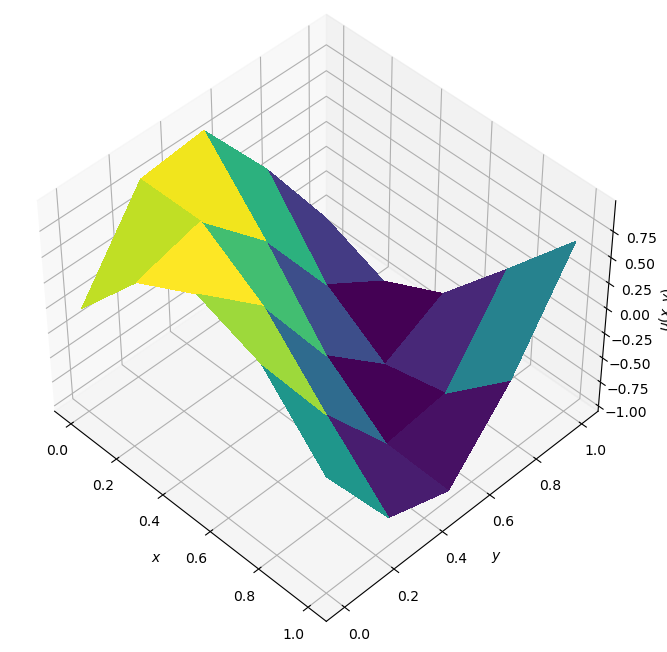

In [4]:
solvePlotHelmholtz(4)

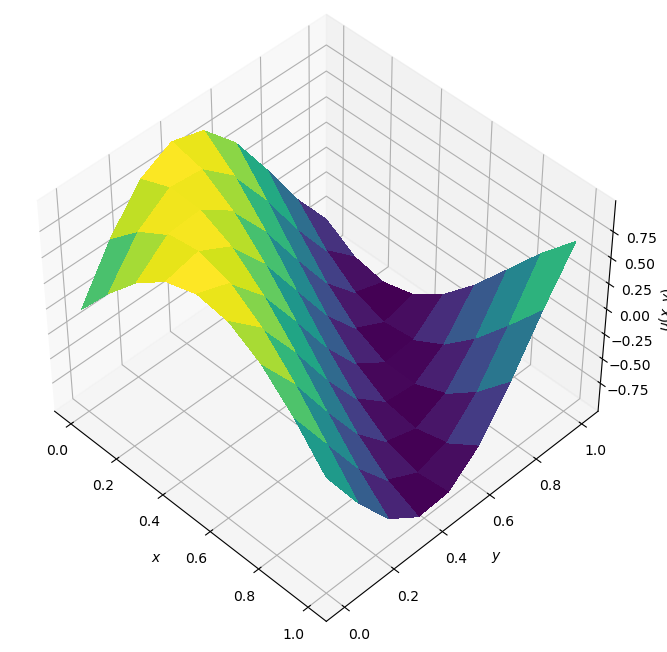

In [5]:
solvePlotHelmholtz(8)

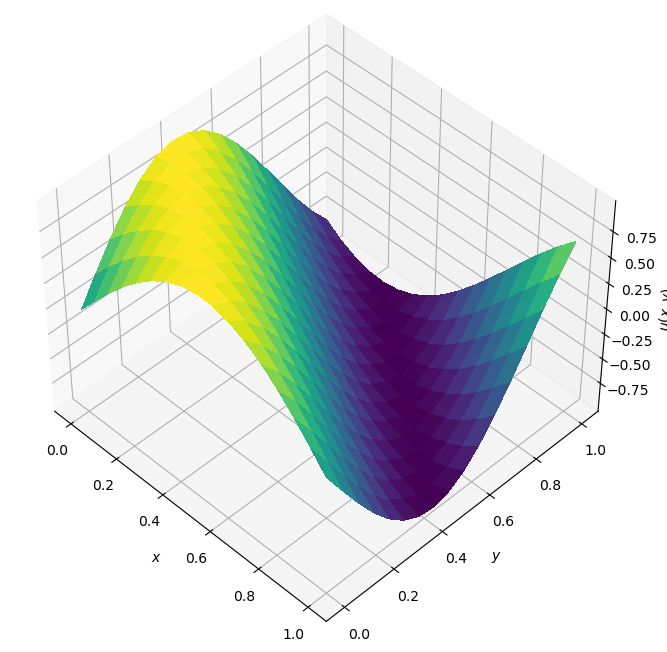

In [6]:
solvePlotHelmholtz(16)

# Part 3: comparing solvers and preconditioners

To decide on which solver to use, it is helpful to uncover some properties of the matrix, as some solvers are suited to certain matrices more than others. Note in this section, I assume that the matrix is symmetric for all $N$, but that is not verified or proven in any way.

Since $\mathrm{A}$ is real and symmetric, and therefore normal, we can calculate the condition number from the minimal and maximal eigenvalues, which would save time over needing to compute the inverse as well as the eigenvalues.

$$\kappa = \frac{|\lambda_{\text{max}}|}{|\lambda_{\text{min}}|}$$

In [7]:
from scipy.sparse.linalg import norm, inv

# First, generate A and b for all N used in this section.
Nlist = [5, 10, 20, 30, 40, 60, 80, 100]
Ablist = [helmholtzMatvec(i) for i in Nlist]

# Calculate the number of non-zeros, density, condition number, and eigenvalues.
cond = []
density = []
eigs = []
nnz = []
for i in range(len(Ablist)):
    A, _ = Ablist[i]
    
    A_nnz = A.getnnz()
    nnz += [A_nnz]
    density += [A_nnz/(A.get_shape()[0]**2)]
    
    # As A is symmetric, we can use eigvalsh. The resulting array is sorted in ascending order.
    A_eigs = np.linalg.eigvalsh(A.todense())
    eigs += [A_eigs]
    cond += [np.fabs(A_eigs[-1])/np.fabs(A_eigs[0])]

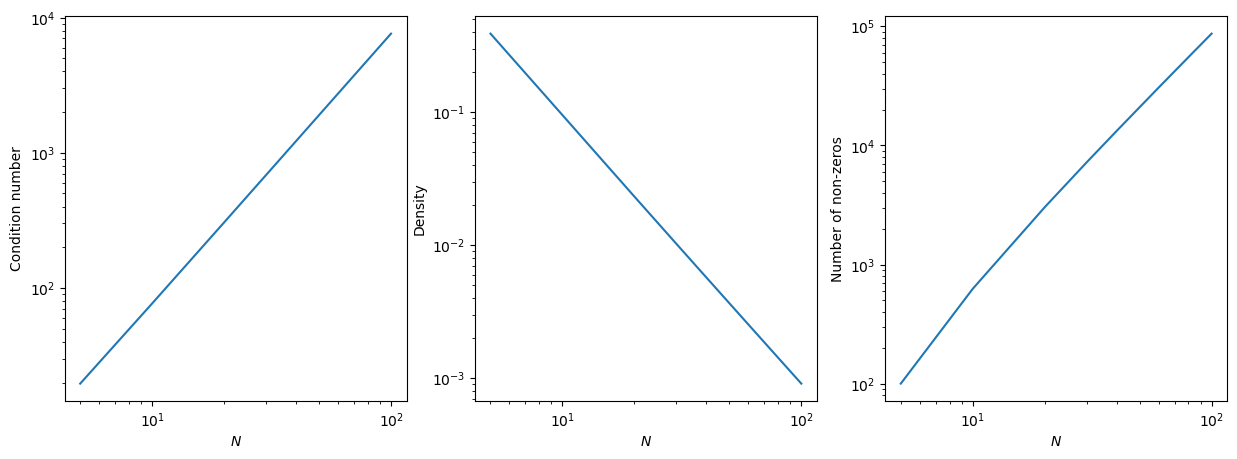

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.plot(Nlist, cond)
ax1.set(xlabel="$N$", ylabel="Condition number")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax2.plot(Nlist, sparsity)
ax2.set(xlabel="$N$", ylabel="Density")
ax2.set_xscale("log")
ax2.set_yscale("log")

ax3.plot(Nlist, nnz)
ax3.set(xlabel="$N$", ylabel="Number of non-zeros")
ax3.set_xscale("log")
ax3.set_yscale("log")
fig.set_size_inches(15,5)

We see that for increasing $N$, the condition number and number of non-zeros grows polynomially, and the density decreases polynomially also. This means that the matrix becomes increasing ill-conditioned for larger $N$, making it harder to solve. The sparsity of the matrix is high for larger $N$, however, so techniques suited for solving sparse matrices will excel in this scenario.

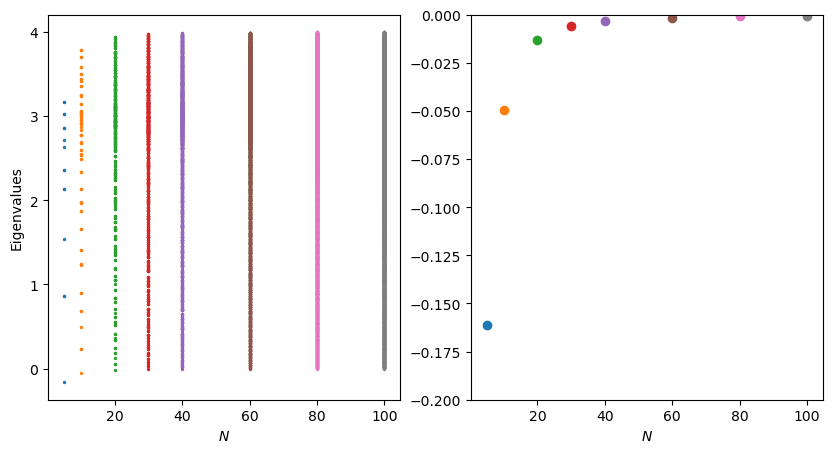

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for i, eig in enumerate(eigs):
    Nval = [Nlist[i]]*len(eig)
    ax1.scatter(Nval, eig, s=2)
    ax2.scatter(Nval, eig)

ax1.set(xlabel="$N$", ylabel="Eigenvalues")
ax2.set(xlabel="$N$")
ax2.set_ylim(-0.2,0)
fig.set_size_inches(10,5)
plt.show()

We see that the matrix's eigenvalues are spread between approximately 0 and 4. As there appears always be one negative eigenvalue, the matrix is not positive definite, though the magnitude of the negative eigenvalue decreases for higher $N$ (This is also why the condition number increases for larger $N$, as we divide by a smaller and smaller denominator).

---

Based on the properties above, I have chosen the following methods, based on the content learnt in the lectures. The two direct methods I chose are as follows:

1. **Inverse matrix**. This is expected to be the slowest method, so this will benchmark the efficiency of the other methods over this one.
2. **LU factorisation**, using the SuperLU library.

Then, we have four direct methods:

1. **GMRES**. Suitable for indefinite nonsymmetric matrices.
2. **Conjugate gradient**. Suitable for symmetric positive definite matrices. As we found out, the matrix is not SPD, and so this method is not expected to converge.
3. **AMG** based on smooth aggregation. Can be used to solve discretisations on irregular grids, and can be used as a preconditioner.
4. **MINRES**. Suitable for symmetric, but not necessarily SPD matrices. According to Paige and Saunders, 1975, (URL `https://stanford.edu/group/SOL/software/symmlq/PS75.pdf`), for symmetric matrices, the iterations are mathematically equivalent to GMRES except that it would require less memory as it doesn't need to store the entire Krylov space. This therefore providing a possible advantage over GMRES.

In [10]:
from pyamg.aggregation import smoothed_aggregation_solver
from scipy.sparse.linalg import gmres, cg, minres
import time
    
def solInverse(A, b):
    """Calculates a (sparse) inverse matrix and multiplies by b to find x. Direct method."""
    Ainv = inv(A)
    x = Ainv @ b
    return x

# solSuperLU already defined before

def solIter(A, b, method, tol=1e-8, find=None):
    """Uses an iterative method (either GMRES, CG, AMG, or MINRES) to find x to a specified tolerance. Optionally returns time or normalised residual per iteration."""
    # define callbacks
    if find == "time":
        times = []
        start_time = time.perf_counter()
        callback = lambda xk: times.append(time.perf_counter() - start_time)
        callback_type = None
        residuals = None
    # here the residuals are normalised (divided by ||b||), as for higher N the initial residual will be larger (if taking x0 all zeros).
    # GMRES and AMG have their own residual callback function, so we have to normalise it afterwards.
    elif find == "res":
        residuals = []
        if method == "GMRES":
            callback = lambda resk: residuals.append(resk)
            callback_type = "pr_norm"
        elif method == "CG" or method == "MINRES":
            callback = lambda xk: residuals.append(np.linalg.norm(b - A@xk)/np.linalg.norm(b))
        elif method == "AMG":
            callback = None # AMG has a seperate parameter for residuals
    elif find is None:
        callback = None
        callback_type = None
        residuals = None
    else:
        raise ValueWarning("find must be one of 'time', 'res', or None")
    
    # methods
    if method == "GMRES":
        x, info = gmres(A, b, tol=tol, callback=callback, callback_type=callback_type) 
    elif method == "CG":
        x, info = cg(A, b, tol=tol, callback=callback)
    elif method == "AMG":
        ml = smoothed_aggregation_solver(A)
        x, info = ml.solve(b, tol=tol, maxiter=800, callback=callback, residuals=residuals, return_info=True)
    elif method == "MINRES":
        x, info = minres(A, b, tol=tol, callback=callback)
    else:
        raise ValueWarning("method must be one of 'GMRES', 'CG', 'AMG', or 'MINRES'")
    
    if info != 0:
        N = int(np.sqrt(b.shape)) + 1
        print(f"{method} did not converge in {info} iterations for N={N}")
    
    # returns
    if find == "time":
        return times
    elif find == "res":
        if method == "GMRES" or method == "AMG":
            # normalise residuals
            residuals = [i/np.linalg.norm(b) for i in residuals]
            return residuals
        else:
            return residuals
    else:
        return x

In [11]:
from timeit import timeit

# First, we just time the different methods for various N.
def compareTime():
    t_inv = timeit("solInverse(A, b)", "from __main__ import A, b, solInverse", number=1)
    t_lu = timeit("solSuperLU(A, b)", "from __main__ import A, b, solSuperLU", number=1)
    t_gmres = timeit("solIter(A, b, 'GMRES')", "from __main__ import A, b, solIter", number=1)
    t_cg = timeit("solIter(A, b, 'CG')", "from __main__ import A, b, solIter", number=1)
    t_amg = timeit("solIter(A, b, 'AMG')", "from __main__ import A, b, solIter", number=1)
    t_minres = timeit("solIter(A, b, 'MINRES')", "from __main__ import A, b, solIter", number=1)
    return t_inv, t_lu, t_gmres, t_cg, t_amg, t_minres

times = np.zeros((6, len(Nlist)))
for i in range(len(Nlist)):
    A, b = Ablist[i]
    t_inv, t_lu, t_gmres, t_cg, t_amg, t_minres = compareTime()
    times[0, i] = t_inv
    times[1, i] = t_lu
    times[2, i] = t_gmres
    times[3, i] = t_cg
    times[4, i] = t_amg
    times[5, i] = t_minres

AMG did not converge in 800 iterations for N=80
AMG did not converge in 800 iterations for N=100


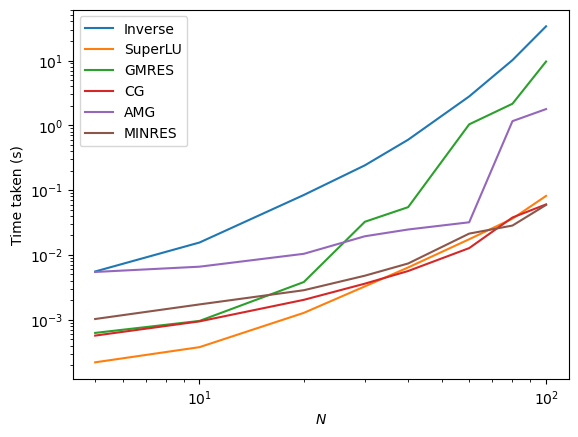

In [12]:
for i in range(6):
    plt.plot(Nlist, times[i, :])

plt.yscale("log")
plt.xscale("log")
plt.xlabel("$N$")
plt.ylabel("Time taken (s)")
plt.legend(["Inverse", "SuperLU", "GMRES", "CG", "AMG", "MINRES"])

Firstly, we see that it is not CG that doesn't converge, but AMG---although only for $N=80$ and $N=100$. More details are given in the iteration investigation below.

Calculating the inverse matrix takes the highest amount of time, as expected. SuperLU excels for low $N$, and is still about as fast as CG and MINRES for high $N$. Its performance is perhaps explained by SuperLU being (a) written in a low-level language, C, and so can more optimised than languages such as Python eg. using SIMD; and (b) uses multiprocessing tools to increase parallelisation.

GMRES' increase in time taken per increase in $N$ (gradient) is the highest of the iterative methods, while AMG has the lowest except for $N=80$ and $N=100$, where we see a jump as it calculates to the maximum allowed number of iterations. CG and MINRES are the best performing iterative solvers. It is expected the MINRES would do well as the properties of the matrix is suitable for this method, although for CG, this is not expected as the matrix is not SPD. According to Paige and Saunders (see citation above), it is possible for CG to solve a system with a non-SPD matrix, although it is not expected to.

In the section below, we take a look at the time and residual progression per iteration for the iterative solvers.

In [13]:
# For the iterative methods, we can also see the time progression for each iteration.
iter_t_gmres = []
iter_t_cg = []
iter_t_amg = []
iter_t_minres = []
for i in range(len(Ablist)):
    A, b = Ablist[i]
    iter_t_gmres.append(solIter(A, b, "GMRES", find="time"))
    iter_t_cg.append(solIter(A, b, "CG", find="time"))
    iter_t_amg.append(solIter(A, b, "AMG", find="time"))
    iter_t_minres.append(solIter(A, b, "MINRES", find="time"))

# And similarly, the residual progression. Note that calculating the residual takes time, so this is done independently.
res_gmres = []
res_cg = []
res_amg = []
res_minres = []
for i in range(len(Ablist)):
    A, b = Ablist[i]
    res_gmres.append(solIter(A, b, "GMRES", find="res"))
    res_cg.append(solIter(A, b, "CG", find="res"))
    res_amg.append(solIter(A, b, "AMG", find="res"))
    res_minres.append(solIter(A, b, "MINRES", find="res"))
    
def plot_res_t(Nlist, iter_t, res, title):
    """Plots the time and residual progression for iterative solvers."""
    fig, (ax1, ax2) = plt.subplots(1, 2)

    for i in range(len(Nlist)):
        ax1.plot(iter_t[i], label="$N=\,$" + str(Nlist[i]))
        ax2.plot(res[i], label="$N=\,$" + str(Nlist[i]))
    ax1.set(xlabel="Iteration", ylabel="Cumulative time taken (s)")
    ax1.set_xlim(0)
    ax1.set_ylim(0)
    ax2.set(xlabel="Iteration", ylabel="Normalised residual")
    ax2.set_xlim(0)
    ax2.set_ylim(1e-10)
    ax2.set_yscale("log")
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(Nlist)/2, bbox_to_anchor=(0.5,-0.1))

    fig.suptitle(title)
    fig.set_size_inches(10,5)
    plt.show()

AMG did not converge in 800 iterations for N=80
AMG did not converge in 800 iterations for N=100
AMG did not converge in 800 iterations for N=80
AMG did not converge in 800 iterations for N=100


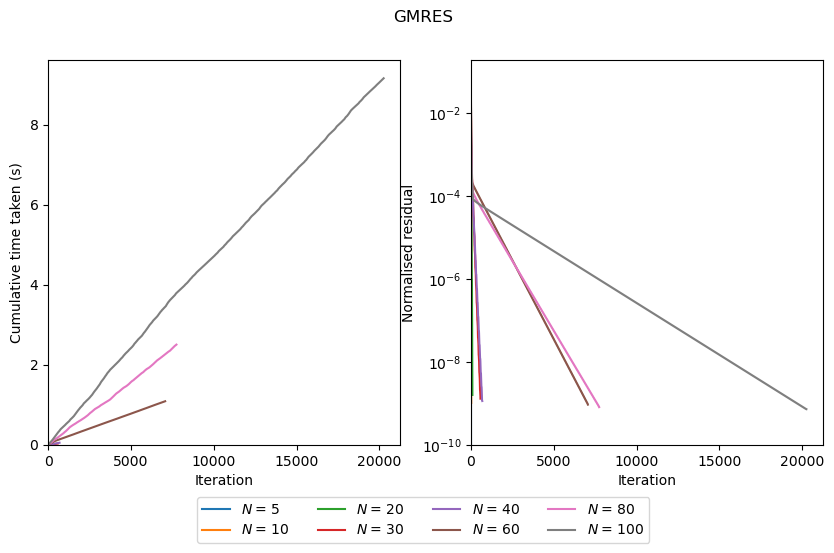

In [14]:
plot_res_t(Nlist, iter_t_gmres, res_gmres, "GMRES")

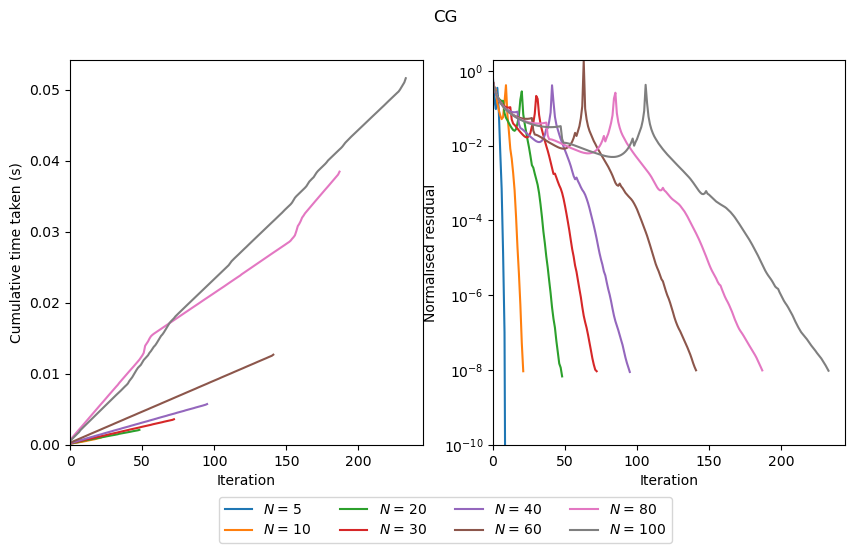

In [15]:
plot_res_t(Nlist, iter_t_cg, res_cg, "CG")

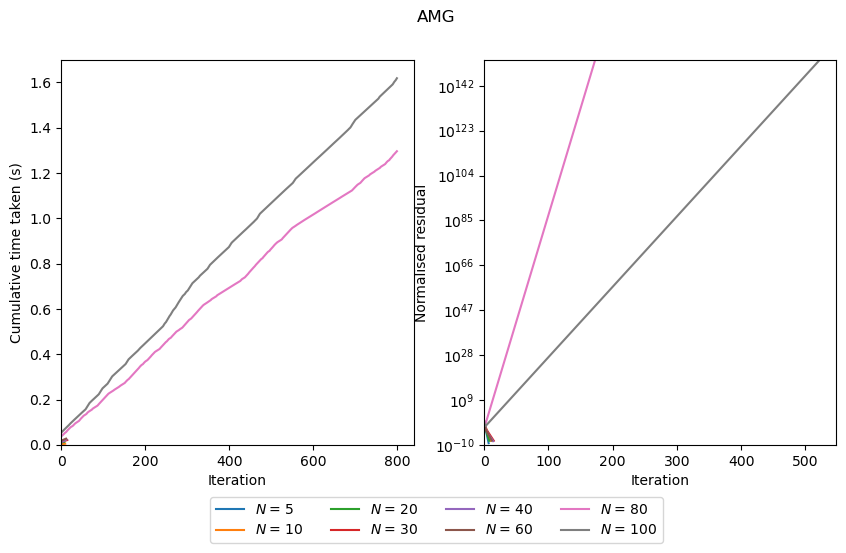

In [16]:
plot_res_t(Nlist, iter_t_amg, res_amg, "AMG")

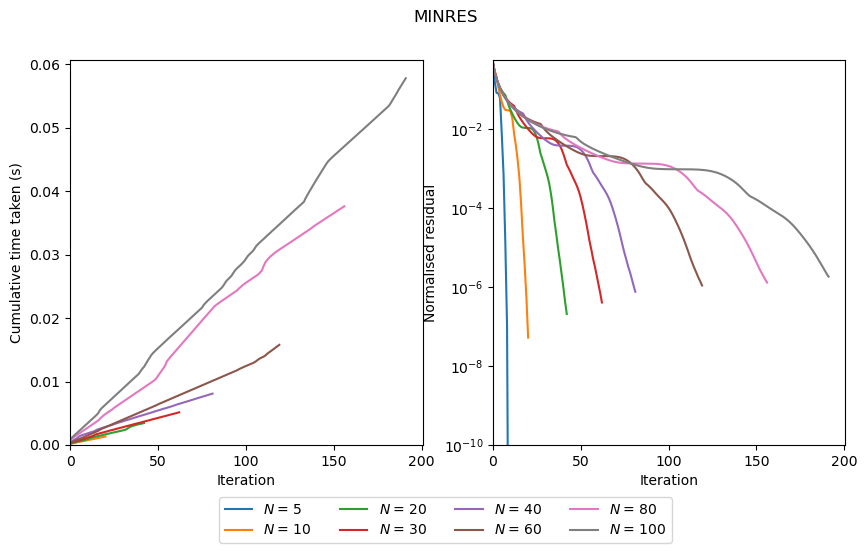

In [17]:
plot_res_t(Nlist, iter_t_minres, res_minres, "MINRES")

From the figures above, we see that for all iterative solvers, the time taken per iteration is roughly constant, plus and minus some possible noise (which can come from, eg. background processes), so this is not particularly interesting. On the other hand, we see the differences in residual per iteration from each iterative method.

+ GMRES takes the largest number of iterations by far, and its residuals decrease exponentially. GMRES' performance for low $N$ can be seen with the abundance of lines on the left side, but for high $N$ the gradient is much lower. One possible reason for GMRES' low performance for high $N$ is the restart parameter (default for SciPy is 20). At every restart, the memory of the previous vectors is cleared and the algorithm starts again with the previously calculated result of $\mathbf{x}_i$. Increasing this could possibly increase performance at the cost of higher memory, although due to the symmetric nature of the matrix, is unlikely to perform better than MINRES.
+ CG's residual progression appears to spike around half of the final iteration, before quickly achieving convergence. This is perhaps due to the fact that $\mathbf{A}$ is non-SPD.
+ The divergence of AMG can be seen clearly for $N=80$ and $N=100$, whose residuals grow exponentially. However, the gradient for $N=100$ is lower than for $N=80$, possibly implying that the method could converge again if $N$ is increased.
+ MINRES differs from GMRES as its residual progression is not exponential. The residual plateaus around half of the final iteration, before quickly achieving convergence, somewhat like CG with its spikes.

Below is the plot of AMG without the non-converging $N$. Interestingly, the gradient of the residual per iteration is not in order of increasing $N$.

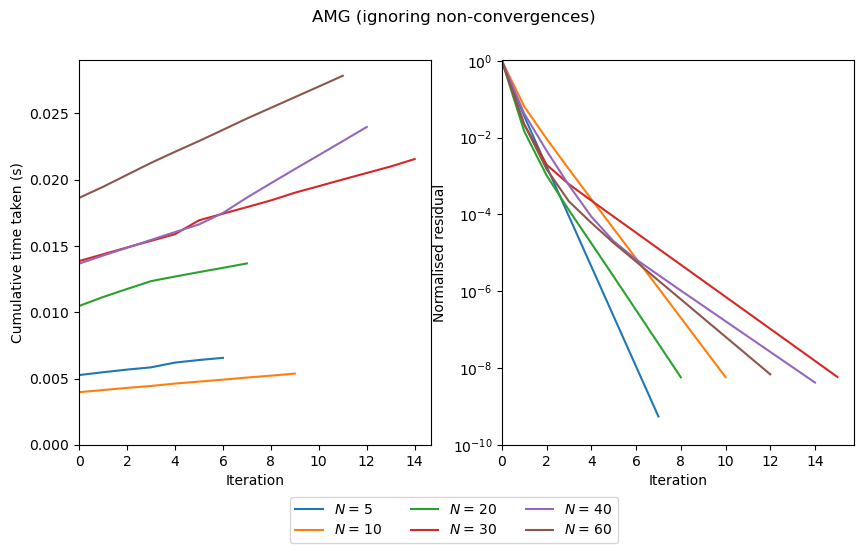

In [18]:
plot_res_t(Nlist[:-2], iter_t_amg[:-2], res_amg[:-2], "AMG (ignoring non-convergences)")

From the results above I decided to choose CG and MINRES as the methods to precondition, as they had converged in the lowest time.

The preconditioners I chose to use are Jacobi, ILU (Incomplete LU factorisation), and AMG (as a preconditioner). As petsc4py doesn't install on my machine, these preconditioners were primarily chosen due to their compatibility with sparse matrices, as conversion to a dense matrix is not ideal.

While I would have liked to use SPAI (Sparse approximate inverse) in the lecture notes, it is written in Python, while SciPy's ILU and pyAMG's AMG are performance-accelerated in C/C++. Ultimately, I considered this too slow for a fair comparison.

**Note**: Using MINRES with AMG results in an error as it complains the preconditioner is not symmetric (even if I set the symmetry parameter to "symmetric"!). In this case, I replaced MINRES with GMRES.

In [19]:
from scipy.sparse import diags
from scipy.sparse.linalg import spilu, LinearOperator

def solIterPrecon(A, b, preconditioner, method, tol=1e-8):
    """Uses an iterative method (either CG or MINRES) with a preconditioner (Jacobi, ILU, or AMG) to find x to a specified tolerance."""
        
    # preconditioners
    if preconditioner == "Jacobi":
        M = diags(A.diagonal(), format="coo")
    elif preconditioner == "ILU":
        M = LinearOperator(matvec=spilu(A, drop_rule="dynamic").solve,
                           shape=A.shape,
                           dtype=A.dtype)
    elif preconditioner == "AMG":
        ml = smoothed_aggregation_solver(A)
        M = ml.aspreconditioner()
    elif preconditioner is None:
        M = None
    else:
        raise ValueWarning("preconditioner must be either one of 'Jacobi', 'ILU', 'AMG', or None")
    
    # methods
    if method == "CG":
        x, info = cg(A, b, M=M, tol=tol, maxiter=800)
    elif method == "MINRES":
        if preconditioner == "AMG":
            x, info = gmres(A, b, M=M, tol=tol, maxiter=800)
        else:
            x, info = minres(A, b, M=M, tol=tol, maxiter=800)
    else:
        raise ValueWarning("method must be either 'CG' or 'MINRES'")
    
    if info != 0:
        N = int(np.sqrt(b.shape)) + 1
        print(f"{method} with {preconditioner} did not converge in {info} iterations for N={N}")

    return x

In [20]:
# Note: The time it takes to precondition the matrix is included.
def compareTimePrecon():
    t_cgj = timeit("solIterPrecon(A, b, 'Jacobi', 'CG')", "from __main__ import A, b, solIterPrecon", number=1)
    t_cgilu = timeit("solIterPrecon(A, b, 'ILU', 'CG')", "from __main__ import A, b, solIterPrecon", number=1)
    t_cgamg = timeit("solIterPrecon(A, b, 'AMG', 'CG')", "from __main__ import A, b, solIterPrecon", number=1)
    t_mrj = timeit("solIterPrecon(A, b, 'Jacobi', 'MINRES')", "from __main__ import A, b, solIterPrecon", number=1)
    t_mrilu = timeit("solIterPrecon(A, b, 'ILU', 'MINRES')", "from __main__ import A, b, solIterPrecon", number=1)
    t_mramg = timeit("solIterPrecon(A, b, 'AMG', 'MINRES')", "from __main__ import A, b, solIterPrecon", number=1)
    return t_cgj, t_cgilu, t_cgamg, t_mrj, t_mrilu, t_mramg

times_precon = np.zeros((6, len(Nlist)))
for i in range(len(Nlist)):
    A, b = Ablist[i]
    t_cgj, t_cgilu, t_cgamg, t_mrj, t_mrilu, t_mramg = compareTimePrecon()
    times_precon[0, i] = t_cgj
    times_precon[1, i] = t_cgilu
    times_precon[2, i] = t_cgamg
    times_precon[3, i] = t_mrj
    times_precon[4, i] = t_mrilu
    times_precon[5, i] = t_mramg

CG with ILU did not converge in 800 iterations for N=60
MINRES with ILU did not converge in 800 iterations for N=60
CG with ILU did not converge in 800 iterations for N=80
MINRES with ILU did not converge in 800 iterations for N=80
CG with ILU did not converge in 800 iterations for N=100


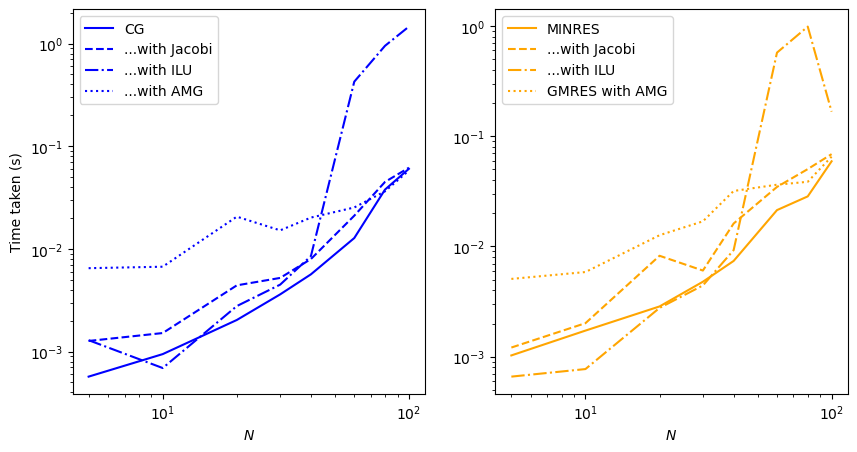

In [21]:
linestyles = ['--', '-.', ':']*2
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(Nlist, times[3, :], color='blue')
for i in range(3):
    ax1.plot(Nlist, times_precon[i, :], color='blue', ls=linestyles[i])

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set(xlabel="$N$", ylabel="Time taken (s)")
ax1.legend(["CG", "...with Jacobi", "...with ILU", "...with AMG"])
    
ax2.plot(Nlist, times[5, :], color='orange')
for i in range(3, 6):
    ax2.plot(Nlist, times_precon[i, :], color='orange', ls=linestyles[i])
    
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set(xlabel="$N$")
ax2.legend(["MINRES", "...with Jacobi", "...with ILU", "GMRES with AMG"])
fig.set_size_inches(10,5)

In the figure above we see the comparison of the time taken using the non-preconditioned method versus the time taken creating the preconditioner and solving the preconditioned system. Unfortunately, it appears that no preconditioner significantly speeds up the time taken for convergence.

The Jacobi preconditioner is one of the simplest and also the fastest to create. However, it is unlikely to approximate the inverse of the matrix very well, and so is generally only used if most of the matrix's non-zero entries are on the diagonal. The Jacobi line lies close to the unpreconditioned line in both methods.

As seen in the print-outs above, ILU causes both methods to diverge for $N=60$ and $N=80$, causing an uptick in the graph for these $N$. However, MINRES with ILU does converge for $N=100$ (while CG does not), which could mean that ILU works for higher $N$ (perhaps similarly to AMG when I compared methods). It's possible changing the drop tolerance and fill factor would fix this, but using the default values, ILU performs poorly in this case.

While AMG works with CG, I am unable to make it work for MINRES, and so GMRES is substituted in this scenario. Preconditioning with AMG does however have the lowest time increase per increase in $N$ of all the scenarios although it does not perform well for low $N$. Therefore, AMG may be a good preconditioner for CG.

The residual progression of the preconditioned systems will not be investigated due to time constraints. Nevertheless, computational time is considered to be the more important measure as the residual progression does not detail the instantiation of the preconditioner itself.

From the evidence shown above, I have chosen MINRES with no preconditioning for the last sections, due to its suitability to the properties of the matrix and its low time to convergence. As AMG does not work with MINRES, I have decided to not choose a preconditioner, as the other options increase the time taken, or cause the method to diverge.

# Part 4: increasing $N$

In [22]:
def u_exact(N):
    """Calculates the exact solution, discretised to a grid of N+1 by N+1 points."""
    inc_val = np.linspace(0, 1, N+1)
    x, y = np.meshgrid(inc_val, inc_val, sparse=True)
    u = np.sin(3*x + 4*y)
    return u

def error(u):
    """Calculates the error of the given finite element grid."""
    assert u.shape[0] == u.shape[1], "Matrix must be square"
    N = u.shape[0] - 1
    h = 1/N
    ux = u_exact(N)
    error = 0
    for i in range(N-1):
        for j in range(N-1):
            submatrix_ux = ux[i:i+2, j:j+2]
            submatrix_uh = u[i:i+2, j:j+2]
            m_x = np.mean(submatrix_ux)
            m_h = np.mean(submatrix_u) 
            error += h**2 * np.fabs(m_x - m_h)
    return error

In [23]:
Nlist = [5, 10, 20, 30, 40, 60, 80, 100, 125, 150, 175, 200, 250, 300]
Ablist = [helmholtzMatvec(i) for i in Nlist]

minres_times = np.zeros(len(Nlist))
minres_errors = np.zeros(len(Nlist))

for i in range(len(Ablist)):
    A, b = Ablist[i]
    minres_times[i] = timeit("solIter(A, b, 'MINRES')", "from __main__ import A, b, solIter", number=1)
    u = arrayToGrid(solIter(A, b, 'MINRES'))
    minres_errors[i] = error(u)

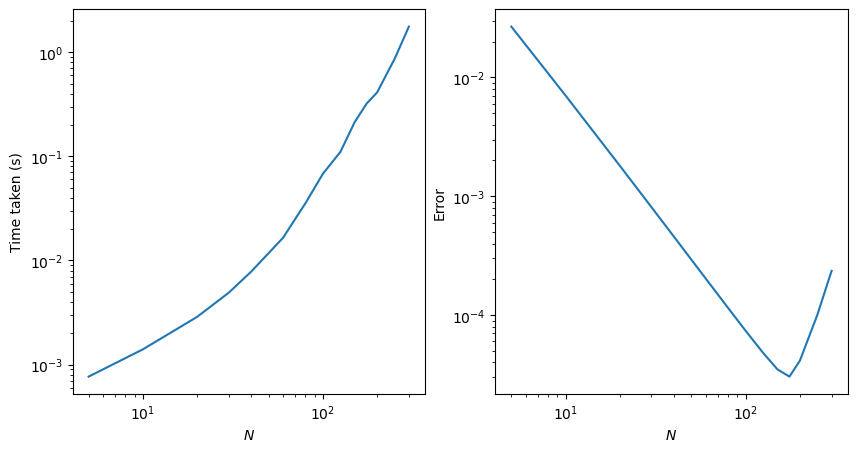

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(Nlist, minres_times)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set(xlabel="$N$", ylabel="Time taken (s)")

ax2.plot(Nlist, minres_errors)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set(xlabel="$N$", ylabel="Error")
fig.set_size_inches(10,5)

To predict the time complexity and order of convergence I will try to use curves of the form $y = ax^b$ for some constants $a, b$. These appear as straight lines on a log-log plot. To do this, I will use `scipy.optimise.curve_fit`, but first I will perform logarithms on both sides, so that `curve_fit`'s least squares method now minimises the square of *the log of* the residual (similar but not the same as the residual in linear algebra), otherwise one would see `curve_fit` overprioritise high $N$.

Note that after a certain threshold ($N=175$), the error starts to increase, possibly due to calculations inside the MINRES method reaching machine epsilon. The fitted curve will ignore this part. 

In [25]:
from scipy.optimize import curve_fit

fit_func = lambda logN, loga, b: loga + b*logN

fit_time, fit_time_cov = curve_fit(fit_func, np.log(Nlist), np.log(minres_times))
# ignore the uptick for high N
fit_error, fit_error_cov = curve_fit(fit_func, np.log(Nlist[:-3]), np.log(minres_errors[:-3]))

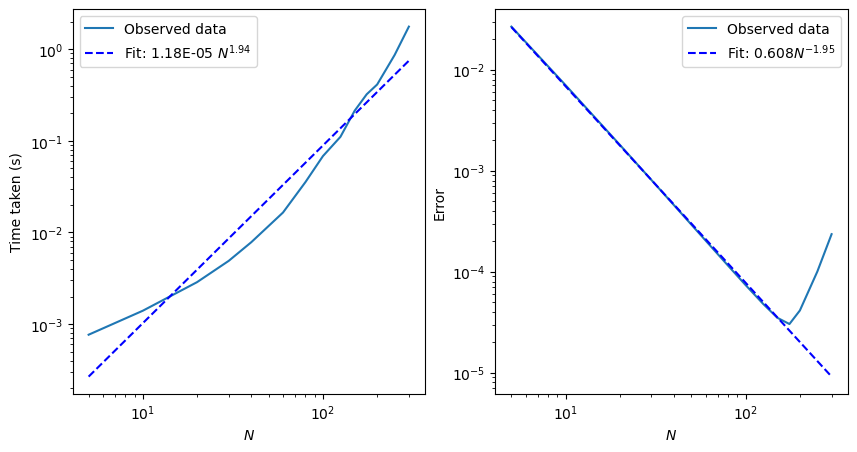

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)

loga, b = fit_time
a = np.exp(loga)

ax1.plot(Nlist, minres_times)
ax1.plot(Nlist, a*Nlist**b, 'b--')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set(xlabel="$N$", ylabel="Time taken (s)")
ax1.legend(["Observed data", "Fit: %.2E $N^{%5.2f}$" % (a, b)])

loga, b = fit_error
a = np.exp(loga)

ax2.plot(Nlist, minres_errors)
ax2.plot(Nlist, a*Nlist**b, 'b--')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set(xlabel="$N$", ylabel="Error")
ax2.legend(["Observed data", "Fit: $%5.3f N^{%5.2f}$" % (a, b)])
fig.set_size_inches(10,5)

We see that using the fitted curves from SciPy, the time complexity of MINRES is approximately $\mathcal{O}(N^2)$ and the order of convergence is approximately 2 (ie. decreases like $\mathcal{O}(N^{-2})$), up to around $N=175$.

# Part 5: parallelisation

There are two parts to solving the Helmholtz wave problem: the creation of the linear system ($\mathrm{A}$ and $\mathbf{b}$) and the method to solve the system (MINRES).

The `helmholtzMatvec` function can easily be parallelised as it has a loop, and the calculation in each iteration is not dependent on the result of any other iteration; a thread can be started for each value for $i \in [0, (N-1)^2]$ and the results collected at the end. The indices of the resulting COO matrix is unlikely to be sorted however as certain threads finish before others. The speed-up of parallelisation is then expected to be approximately the original unparallelised time divided by the number of threads. To perform this parallelisation using numba, one has to define a numba-jitted wrapper function to calculate `row`, `col`, and `data`, which can then be passed onto a regular function which can collect it into the COO array as numba does not support instantiation of sparse matrices.

On the other hand, `MINRES` is an algorithm which is not particularly parallelisable. An overview of the algorithm can be seen in S.-C. Choi, 2006 (URL `https://web.stanford.edu/group/SOL/dissertations/sou-cheng-choi-thesis.pdf`) and the relevant listings are reproduced below:

![MINRES](img/minres.png)

We see that while MINRES does have a loop, the calculation in each iteration *is* dependent on the previous one, which prevents effective parallelisation as each thread would have to wait for the previous iteration to finish. However, at each step in each iteration, multiple variables are calculated, eg. within the Lanczos step, or $\tau_k, \phi_k, \psi_{k-1}$ on line 13. Threads can be assigned to calculate each variable in this case, although the speed-up increase is likely to be very small, and would not benefit with an increased number of threads.